# CSRNet

This notebook is divided into 4 sections:

1. **Training using the authors' code**

  We will first reuse the authors' PyTorch implementation, to compare its performance with our own implementation and various experiments we did, utilizing different optimizers, loss functions, and learning rates.

2.   **Transfer Learning**

  Here, we perform Transfer Learning using a pre-trained CSRNet model. The objective is to examine whether a powerful yet general model, suitable for varying crowd sparsity, can perform as well as a more specific but less tuned model.

  The weights that we will use are already part of a PyPi package called [csrnet](https://pypi.org/project/csrnet/#description) (Note: this package works only as a regressor). They are available to download from the following repo: https://github.com/pschaus/csrnet_pip/blob/main/csrnet.

3.   **Fine-tunning**

  In this section, we attempt to fine-tune the weights used in Section 2. We reuse the authors' code, this time passing the weights as an input argument to initialize the model's weights.

4.   **Regressor**

  Finally, we attempt to use the CSRNet as a feature extractor, and by adding dense layers, we aim to train a network for performing regression directly.



## Imports

**Run this**, since it's general for all the experiments.

Import needed modules:

In [1]:
import os
import shutil
import requests
from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt, cm as cm
import numpy as np
import scipy.io as io
from scipy.ndimage import gaussian_filter
from scipy.spatial import KDTree
import cv2
import h5py
from sklearn.model_selection import train_test_split
import json
from google.colab import drive
import PIL.Image as Image
import torchvision.transforms.functional as F
from torchvision import datasets, transforms
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import argparse
from torch.nn import functional as F
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Downloading data and GT generation

**Important**: Run this only the first time!

Before we clone the repository, we need to download the Mall dataset, and generate the ground truth density maps.

### Download Mall Dataset

We will download the dataset from this url: https://personal.ie.cuhk.edu.hk/~ccloy/downloads_mall_dataset.html

**Important**: Run this only the first time!

In [ ]:
# Define the URL of the zip file
url = 'https://personal.ie.cuhk.edu.hk/~ccloy/files/datasets/mall_dataset.zip'

# Define the destination path in Google Drive
destination_path = '/content/drive/MyDrive/CrowdCounting/Data/'
# mall_dataset folder is contained in the zip

# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Download the file
response = requests.get(url, stream=True)
zip_path = os.path.join(destination_path, 'mall_dataset.zip')

with open(zip_path, 'wb') as f:
    shutil.copyfileobj(response.raw, f)

# Extract the contents of the zip file
shutil.unpack_archive(zip_path, destination_path)

# Clean up: remove the downloaded zip file
os.remove(zip_path)

Let's delete Thumbs.db from the frames folder.

In [ ]:
directory_path = "/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/frames/"

# List all files in the directory
file_list = os.listdir(directory_path)

# Check if "Thumbs.db" exists in the list
if "Thumbs.db" in file_list:
    # Construct the full file path
    thumbs_db_path = os.path.join(directory_path, "Thumbs.db")

    # Delete the file
    os.remove(thumbs_db_path)
    print("Thumbs.db deleted successfully.")
else:
    print("Thumbs.db not found in the directory.")

Thumbs.db deleted successfully.


### Generate Density Maps

Here we generate the ground truth density maps and store them to Google Drive.

**Important**: Run this only the first time!

In [ ]:
# Borrowed from the original author's code:
# https://github.com/leeyeehoo/CSRNet-pytorch/blob/master/make_dataset.ipynb
def gaussian_filter_density(ground_truth):
    '''Generates a density map using Gaussian filter transformation.'''
    density = np.zeros(ground_truth.shape, dtype=np.float32) # Initialize an empty density map with the same shape as the GT
    ground_truth_count = np.count_nonzero(ground_truth) # count of people in the image

    if ground_truth_count == 0: # no people in the image
        return density

    # Find out the K nearest neighbours for each non-zero point using a KDTree
    index_of_nonzero_elements = np.nonzero(ground_truth)
    points = np.array(list(zip(index_of_nonzero_elements[1].ravel(), index_of_nonzero_elements[0].ravel())))
    leafsize = 2048

    # build KDTree
    tree = KDTree(points.copy(), leafsize=leafsize)
    # query KDTree
    distances, _ = tree.query(points, k=4) # 3+1

    for i, point in enumerate(points): # for every person in the image
        point_2d = np.zeros(ground_truth.shape, dtype=np.float32)
        point_2d[point[1], point[0]] = 1.
        if ground_truth_count > 1:
            # sigma = beta * d_bar = 0.3 * (d1 + d2 + d3) / 3 = 0.1 * (d1 + d2 + d3)
            sigma = (distances[i][1] + distances[i][2] + distances[i][3]) * 0.1
        else:
            sigma = np.average(np.array(ground_truth.shape))/2./2. # case: 1 point (person)

        # Convolve with the gaussian filter
        density += gaussian_filter(point_2d, sigma, mode='constant')
    return density


def create_density_maps_mall(imgs_paths, head_positions_gt, save_path):

    for i, img_path in tqdm(enumerate(img_paths), total=len(img_paths)):
        img = plt.imread(img_path)

        ground_truth = head_positions_gt[i][0][0][0]
        # ground truth has rows = #num people.
        # each row is (x,y) representing the central pixel of a head in the image.

        # The following is done as per the original authors' code:
        # https://github.com/leeyeehoo/CSRNet-pytorch/blob/master/make_dataset.ipynb


        # Create a zero matrix of image size
        k = np.zeros((img.shape[0],img.shape[1]))

        # Generate hot encoded matrix of sparse matrix
        for j in range(len(ground_truth)):
            if int(ground_truth[j][1]) < img.shape[0] and int(ground_truth[j][0]) < img.shape[1]:
                k[int(ground_truth[j][1]), int(ground_truth[j][0])] = 1

        # Generate density map
        k = gaussian_filter_density(k)

        with h5py.File(img_path.replace('.jpg','.h5').replace('images','density_maps'), 'w') as hf:
            hf['density'] = k

In [ ]:
mall_dataset_folder = '/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/'
mall_imgs_folder = mall_dataset_folder + 'frames/'
img_paths = []
for img_path in glob(os.path.join(mall_imgs_folder, '*.jpg')):
  img_paths.append(img_path)
print(f'Number of images: {len(img_paths)}.\n')

Number of images: 2000.



In [ ]:
mall_gt = io.loadmat(os.path.join(mall_dataset_folder, 'mall_gt.mat'))
mall_head_positions_gt = mall_gt['frame'][0]

In [ ]:
save_path = '/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/density_maps/'

# Create directory if it doesn't exist
if not os.path.exists(os.path.dirname(save_path)):
    os.makedirs(os.path.dirname(save_path))

create_density_maps_mall(img_paths, mall_head_positions_gt, save_path)

100%|██████████| 2000/2000 [1:03:06<00:00,  1.89s/it]


Display some:

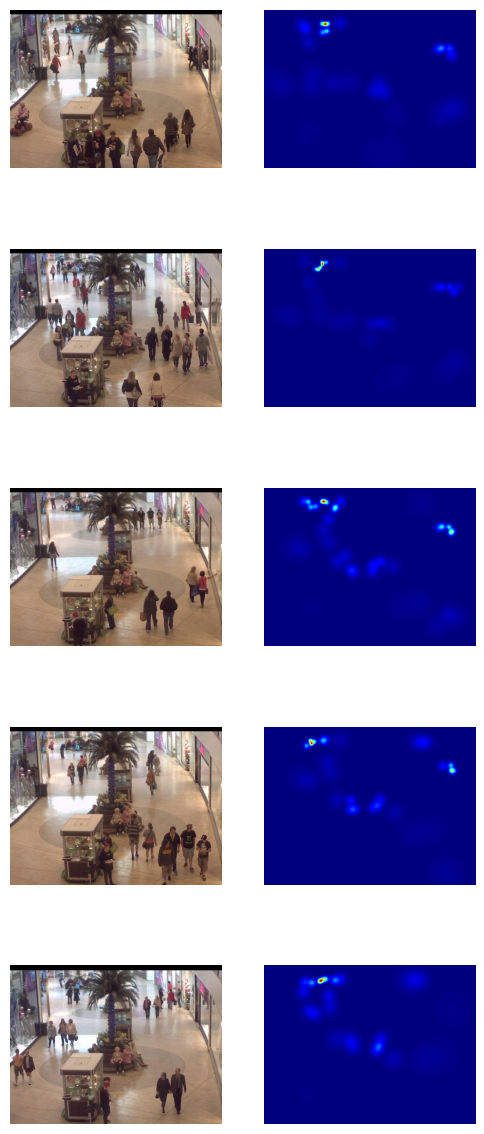

In [ ]:
path_images = '/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/frames/'
path_density_maps = '/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/density_maps/'

to_print = 5
plt.figure(figsize=(6, 3 * to_print))

for i, (img_name, den_name) in enumerate(zip(os.listdir(path = path_images), os.listdir(path = path_density_maps))):
    if i == to_print:
      break
    img = cv2.cvtColor(cv2.imread(path_images + img_name), cv2.COLOR_BGR2RGB)
    ds_map = h5py.File(path_density_maps + den_name)
    ds_map = np.asarray(ds_map['density'])

    plt.subplot(to_print, 2, i * 2 + 1)
    plt.axis("off")
    plt.imshow(img)
    plt.subplot(to_print, 2, (i+1) * 2)
    plt.axis("off")
    plt.imshow(ds_map, cmap = cm.jet)

## CSRNet implementation

**Run this**, since it's general for all the experiments.

In [3]:
# Code borrowed from:
# https://github.com/leeyeehoo/CSRNet-pytorch/blob/master/model.py.

def load_net(fname, net):
    with h5py.File(fname, 'r') as h5f:
        for k, v in net.state_dict().items():
            param = torch.from_numpy(np.asarray(h5f[k]))
            v.copy_(param)

def make_layers(cfg, in_channels = 3, batch_norm = False, dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2, stride = 2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size = 3, padding = d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat, in_channels=512, dilation=True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        # load vgg16 weights on the frontend (transfer learning)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

def load_data(img_path):
    img = Image.open(img_path).convert('RGB')
    return img

## Load data and Train-val-test split

**Run this**, since it's general for all the experiments.

In [4]:
# Load images and density maps
path_dataset = '/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/frames/'

img_names = sorted([file for file in os.listdir(path=path_dataset) if file.lower().endswith('.jpg')])
den_names = sorted([file for file in os.listdir(path=path_dataset) if file.lower().endswith('.h5')])

random_state = 42

# Train_val - test split:
test_proportion = 0.2
train_val_img_names, test_img_names = train_test_split(img_names, test_size=test_proportion, random_state=random_state)
train_val_den_names, test_den_names = train_test_split(den_names, test_size=test_proportion, random_state=random_state)

# Train - val split
val_proportion = 0.1
train_img_names, val_img_names = train_test_split(train_val_img_names, test_size=val_proportion, random_state=random_state)
train_den_names, val_den_names = train_test_split(train_val_den_names, test_size=val_proportion, random_state=random_state)

In [5]:
mall_dataset_folder = '/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/'

mall_gt = io.loadmat(os.path.join(mall_dataset_folder, 'mall_gt.mat'))
mall_head_positions_gt = mall_gt['frame'][0]

num_heads_list = []
for gt in mall_head_positions_gt:
  n_heads = len(gt[0][0][0])
  num_heads_list.append(n_heads)

test_indices = [img_names.index(name) for name in test_img_names]
Test_labels = [num_heads_list[idx] for idx in test_indices]

print(f'{len(Test_labels)} test targets loaded.')

400 test targets loaded.


## (1) Training using the authors' code

Here we clone the **official PyTorch implementation of CSRNet**, and use it to train on a smaller portion of the Mall dataset.

> https://github.com/leeyeehoo/CSRNet-pytorch

### Train-val-test split

We do this in order to generate .json files and store them to Google Drive.

**Important**: Run this only the first time!

For some reason, the code expects both the density maps and original images to be in the same folder, so let's move them:

In [ ]:
old_path = '/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/density_maps'
new_path = '/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/frames/'

# Ensure the destination folder exists; create it if necessary
os.makedirs(new_path, exist_ok=True)

all_files = os.listdir(old_path)

h5_files = [file for file in all_files if file.endswith('.h5')]

# Move each .h5 file to the new path
for h5_file in h5_files:
    source_file_path = os.path.join(old_path, h5_file)
    destination_file_path = os.path.join(new_path, h5_file)
    shutil.move(source_file_path, destination_file_path)

print("Files moved successfully.")

Files moved successfully.


Create json files for just the train, val and test images. For the density maps it's not needed - this is handled in code.

**Important:** Since the code does data augmentation and uses SGD (batch_size=1), it is very slow. Therefore, just for our experimental purposes we will keep a small portion of the dataset.

As we can see below, for 243 train images we obtain 243 * 4 = 972 training samples. If we were to keep the whole dataset, we would obtain 1440 * 4 = 5760 training samples.

In [ ]:
# Load images and density maps
path_dataset = '/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/frames/'

img_names = sorted([file for file in os.listdir(path=path_dataset) if file.lower().endswith('.jpg')])
den_names = sorted([file for file in os.listdir(path=path_dataset) if file.lower().endswith('.h5')])

random_state = 42

# Train_val - test split:
test_proportion = 0.1
train_val_img_names, test_img_names = train_test_split(img_names, test_size=test_proportion, random_state=random_state)
train_val_den_names, test_den_names = train_test_split(den_names, test_size=test_proportion, random_state=random_state)

# Train - val split
val_proportion = 0.2
train_img_names, val_img_names = train_test_split(train_val_img_names, test_size=val_proportion, random_state=random_state)
train_den_names, val_den_names = train_test_split(train_val_den_names, test_size=val_proportion, random_state=random_state)

train_img_names = [os.path.join(path_dataset, img) for img in train_img_names]
val_img_names = [os.path.join(path_dataset, img) for img in val_img_names]
test_img_names = [os.path.join(path_dataset, img) for img in test_img_names]
# train_den_names = [os.path.join(path_dataset, img) for img in train_den_names]
# val_den_names = [os.path.join(path_dataset, img) for img in val_den_names]
# test_den_names = [os.path.join(path_dataset, img) for img in test_den_names]

print('Size of the whole dataset:', len(img_names))

print('Size of the train dataset:', len(train_img_names))
print('Size of the val dataset:', len(val_img_names))
print('Size of the test dataset:', len(test_img_names))
print()

json_save_path = '/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/'

# Save lists as JSON
def save_json(file_paths, file_name):
    json_file_path = os.path.join(json_save_path, f'{file_name}.json')
    with open(json_file_path, 'w') as json_file:
        json.dump(file_paths, json_file)
    print(f"File paths for {file_name} saved to {json_file_path}.")

save_json(train_img_names, 'train_img')
save_json(val_img_names, 'val_img')
save_json(test_img_names, 'test_img')
# save_json(train_den_names, 'train_den')
# save_json(val_den_names, 'val_den')
# save_json(test_den_names, 'test_den')

proportion_of_images_to_keep = 0.15
if proportion_of_images_to_keep < 1:
  train_img_names_reduced = train_img_names[:int(len(train_img_names) * proportion_of_images_to_keep)]
  val_img_names_reduced = val_img_names[:int(len(val_img_names) * proportion_of_images_to_keep)]
  print()
  print('Size of the reduced train dataset:', len(train_img_names_reduced))
  print('Size of the reduced val dataset:', len(val_img_names_reduced))
  print('Size of the test dataset:', len(test_img_names), " -> The test set remains the same.")
  print()
  save_json(train_img_names_reduced, 'train_img_reduced')
  save_json(val_img_names_reduced, 'val_img_reduced')
# Test stays the same.

Size of the whole dataset: 2000
Size of the train dataset: 1440
Size of the val dataset: 360
Size of the test dataset: 200

File paths for train_img saved to /content/drive/MyDrive/CrowdCounting/Data/mall_dataset/train_img.json.
File paths for val_img saved to /content/drive/MyDrive/CrowdCounting/Data/mall_dataset/val_img.json.
File paths for test_img saved to /content/drive/MyDrive/CrowdCounting/Data/mall_dataset/test_img.json.

Size of the reduced train dataset: 216
Size of the reduced val dataset: 54
Size of the test dataset: 200  -> The test set remains the same.

File paths for train_img_reduced saved to /content/drive/MyDrive/CrowdCounting/Data/mall_dataset/train_img_reduced.json.
File paths for val_img_reduced saved to /content/drive/MyDrive/CrowdCounting/Data/mall_dataset/val_img_reduced.json.


### Cloning and code modifications

**Important**: This is to be done just the first time.

In [ ]:
!git clone https://github.com/leeyeehoo/CSRNet-pytorch.git

Cloning into 'CSRNet-pytorch'...
remote: Enumerating objects: 86, done.
remote: Total 86 (delta 0), reused 0 (delta 0), pack-reused 86
Receiving objects: 100% (86/86), 622.25 KiB | 18.30 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [ ]:
%cd CSRNet-pytorch

/content/CSRNet-pytorch


In [ ]:
%ls

dataset.py          part_A_test.json            part_B_train.json           utils.py
image.py            part_A_train.json           part_B_train_with_val.json  val.ipynb
make_dataset.ipynb  part_A_train_with_val.json  part_B_val.json
make_model.ipynb    part_A_val.json             README.md
model.py            part_B_test.json            train.py


The following changes are needed:

* model.py:

        xrange -> range
        list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]

* image.py

        target = cv2.resize(target,(target.shape[1]//8,target.shape[0]//8),interpolation = cv2.INTER_CUBIC)*64

* train.py

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        Add device to global variables in main.
        .cuda() -> to(device)
        torch.manual_seed(args.seed)
        os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu -> if torch.cuda.is_available(): device = torch.device("cuda:" + args.gpu)

Finally, **modify the number of epochs**. The code uses 400, but that is too much for a free version of Colab. We set epochs to a lower number (**20**) to be somewhat consistent with our own CSRNet implementation. We didn't use 40, because this code was much slower.


Finally we save the modified file to our Google Drive, to avoid having to download and modify the code over and over again.

In [ ]:
%cp -a /content/CSRNet-pytorch /content/drive/MyDrive/CrowdCounting/CSRNet-pytorch
print('Folder copied successfully.')

Folder copied successfully.


In [ ]:
%ls /content/drive/MyDrive/CrowdCounting/CSRNet-pytorch

dataset.py          part_A_test.json            part_B_train.json           utils.py
image.py            part_A_train.json           part_B_train_with_val.json  val.ipynb
make_dataset.ipynb  part_A_train_with_val.json  part_B_val.json
make_model.ipynb    part_A_val.json             README.md
model.py            part_B_test.json            train.py


### Training


In [ ]:
%cd /content/drive/MyDrive/CrowdCounting/CSRNet-pytorch/

/content/drive/MyDrive/CrowdCounting/CSRNet-pytorch


In [ ]:
%ls

dataset.py          part_A_test.json            part_B_train.json           train.py
image.py            part_A_train.json           part_B_train_with_val.json  utils.py
make_dataset.ipynb  part_A_train_with_val.json  part_B_val.json             val.ipynb
make_model.ipynb    part_A_val.json             __pycache__/
model.py            part_B_test.json            README.md


In [ ]:
!python train.py /content/drive/MyDrive/CrowdCounting/Data/mall_dataset/train_img_reduced.json /content/drive/MyDrive/CrowdCounting/Data/mall_dataset/val_img_reduced.json 0 no_pretrain_


Using device: cuda:0 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 528M/528M [00:06<00:00, 91.7MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.form

In [ ]:
%ls

dataset.py          no_pretrain_checkpoint.pth.tar  part_A_val.json             __pycache__/
image.py            no_pretrain_model_best.pth.tar  part_B_test.json            README.md
make_dataset.ipynb  part_A_test.json                part_B_train.json           train.py
make_model.ipynb    part_A_train.json               part_B_train_with_val.json  utils.py
model.py            part_A_train_with_val.json      part_B_val.json             val.ipynb


In [ ]:
%pwd

'/content/drive/MyDrive/CrowdCounting/CSRNet-pytorch'

In [ ]:
# Define source paths, new file names, and destination folder (in Google Drive)
source_paths = ["/content/drive/MyDrive/CrowdCounting/CSRNet-pytorch/no_pretrain_checkpoint.pth.tar", "/content/drive/MyDrive/CrowdCounting/CSRNet-pytorch/no_pretrain_model_best.pth.tar"]
new_names = ["mall_dataset_authors_code_no_pretrain_checkpoint.pth.tar", "mall_dataset_authors_code_no_pretrain_best_model.pth.tar"]
destination_folder = "/content/drive/MyDrive/CrowdCounting/Models/"

# Copy and rename files to Google Drive
for source_path, new_name in zip(source_paths, new_names):
    destination_path = os.path.join(destination_folder, new_name)
    shutil.copy(source_path, destination_path)

print("Files renamed and moved to Google Drive.")

Files renamed and moved to Google Drive.


### Testing

Let's see how the model trained on a small portion of the training dataset performs on the test set.

In [ ]:
# Define the path to the JSON file
json_file_path = "/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/test_img.json"

# Load the JSON file
with open(json_file_path, 'r') as file:
    test_paths = json.load(file)

print(len(test_paths))

200


In [ ]:
%pwd

'/content/drive/MyDrive/CrowdCounting/CSRNet-pytorch'

In [ ]:
from model import CSRNet

destination_folder = "/content/drive/MyDrive/CrowdCounting/Models/"
best_model_path = os.path.join(destination_folder, 'mall_dataset_authors_code_no_pretrain_checkpoint.pth.tar')

model = CSRNet()

checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['state_dict'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


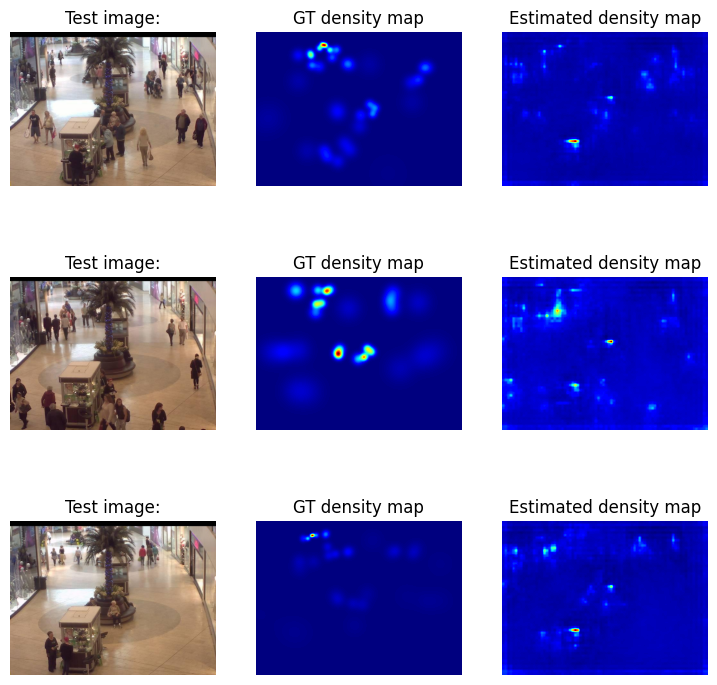

In [ ]:
to_print = 3
plt.figure(figsize=(9, 3 * to_print))

for i, test_path in enumerate(test_paths):
    if i == to_print: break

    img = transform(Image.open(test_path).convert('RGB'))
    output = model(img.unsqueeze(0))

    estimated_den_map = output.squeeze().detach().numpy()

    img = Image.open(test_path).convert('RGB')

    gt_file = h5py.File(test_path.replace('.jpg','.h5').replace('images','ground_truth'),'r')
    den_map = np.asarray(gt_file['density'])

    plt.subplot(to_print, 3, i * 3 + 1)
    plt.axis("off")
    plt.title("Test image:")
    plt.imshow(img)

    plt.subplot(to_print, 3, i * 3 + 2)
    plt.axis("off")
    plt.title("GT density map")
    plt.imshow(den_map , cmap = cm.jet)
    print()

    estimated_count = np.sum(estimated_den_map)
    plt.subplot(to_print, 3, i * 3 + 3)
    plt.axis("off")
    plt.title(f"Estimated density map")
    plt.imshow(estimated_den_map, cmap = cm.jet)

In [ ]:
mae = 0

for test_path in tqdm(test_paths, desc='Calculating MAE', unit='image'):
    img = transform(Image.open(test_path).convert('RGB'))
    img = img.to(device)

    gt_file = h5py.File(test_path.replace('.jpg','.h5').replace('images','ground_truth'),'r')
    groundtruth = np.asarray(gt_file['density'])

    output = model(img.unsqueeze(0))

    mae += abs(output.detach().cpu().sum().numpy() - np.sum(groundtruth))

print('\nMAE:', mae / len(test_paths))

Calculating MAE: 100%|██████████| 200/200 [04:13<00:00,  1.27s/image]


MAE: 5.184046802520752


**Analysis**:

> Concidering that we trained using just 15% of the available training set, the obtained MAE is decent. It's evident that **data augmentation** helps. Also, more epochs are needed. We did only 20, which still took a long time to train.

> **We expect that longer training and more training data would improve the performance** drastically, but we are dealing with limited resources, so let's utilize **Transfer learning**.

## (2) Transfer learning

We will be reusing the weights from: https://github.com/pschaus/csrnet_pip/blob/main/csrnet.

First upload the weights to Google Drive.
> /content/drive/MyDrive/CrowdCounting/Models/weights_pschaus.npz

In [ ]:
%ls /content/drive/MyDrive/CrowdCounting/Models/weights_pschaus.npz

/content/drive/MyDrive/CrowdCounting/Models/weights_pschaus.npz


In [ ]:
model = CSRNet()
model.cuda()

checkpoint = np.load("/content/drive/MyDrive/CrowdCounting/Models/weights_pschaus.npz")

checkpoint = { layer: torch.from_numpy(mat) for layer,mat in checkpoint.items() }
model.load_state_dict(checkpoint)

Let's check if the code works for a single image:

In [ ]:
filepath = '/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/frames/seq_000001.jpg' # Path to image

transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225]),])

img = transform(Image.open(filepath).convert('RGB')).cuda()
output = model(img.unsqueeze(0))

print(int(output.detach().cpu().sum().numpy()))

32


Since it works, let's try **inference** on the test dataset.

First, let's do train-val-test split:

In [ ]:
# Load images and density maps
path_dataset = '/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/frames/'

img_names = sorted([file for file in os.listdir(path=path_dataset) if file.lower().endswith('.jpg')])
den_names = sorted([file for file in os.listdir(path=path_dataset) if file.lower().endswith('.h5')])

random_state = 42

# Train_val - test split:
test_proportion = 0.2
train_val_img_names, test_img_names = train_test_split(img_names, test_size=test_proportion, random_state=random_state)
train_val_den_names, test_den_names = train_test_split(den_names, test_size=test_proportion, random_state=random_state)

# Train - val split
val_proportion = 0.1
train_img_names, val_img_names = train_test_split(train_val_img_names, test_size=val_proportion, random_state=random_state)
train_den_names, val_den_names = train_test_split(train_val_den_names, test_size=val_proportion, random_state=random_state)

Let's load the targets:

In [ ]:
mall_dataset_folder = '/content/drive/MyDrive/CrowdCounting/Data/mall_dataset/'

mall_gt = io.loadmat(os.path.join(mall_dataset_folder, 'mall_gt.mat'))
mall_head_positions_gt = mall_gt['frame'][0]

num_heads_list = []
for gt in mall_head_positions_gt:
  n_heads = len(gt[0][0][0])
  num_heads_list.append(n_heads)

test_indices = [img_names.index(name) for name in test_img_names]
Test_labels = [num_heads_list[idx] for idx in test_indices]

print(f'{len(Test_labels)} test targets loaded.')

400 test targets loaded.


**Testing**

Let's see whether how efficient are these weights for a new dataset, i.e., the test partition of the Mall dataset.

In [ ]:
mse_error = 0
mae_error = 0
mape_error = 0
N = len(Test_labels)

for (img_name, target) in tqdm(zip(test_img_names, Test_labels), total=len(Test_labels)):
    img = transform(Image.open(path_dataset + img_name).convert('RGB')).cuda()
    output = model(img.unsqueeze(0))
    prediction = int(output.detach().cpu().sum().numpy())
    mse_error += np.mean(np.square(np.sum(prediction) - target))
    mae_error += np.mean(np.abs(np.sum(prediction) - target))
    mape_error += np.mean(np.abs((np.sum(prediction) - target) / target)) * 100

mse = round(mse_error / N, 2)
mae = round(mae_error / N, 2)
mape = round(mape_error / N, 2)

print(f'\n\nMSE: {mse}, MAE: {mae}, MAPE: {mape}')
# MSE: 17.95, MAE: 3.44, MAPE: 11.52

100%|██████████| 400/400 [02:13<00:00,  2.99it/s]



MSE: 17.95, MAE: 3.44, MAPE: 11.52


Finally, let's visualize some predictions:

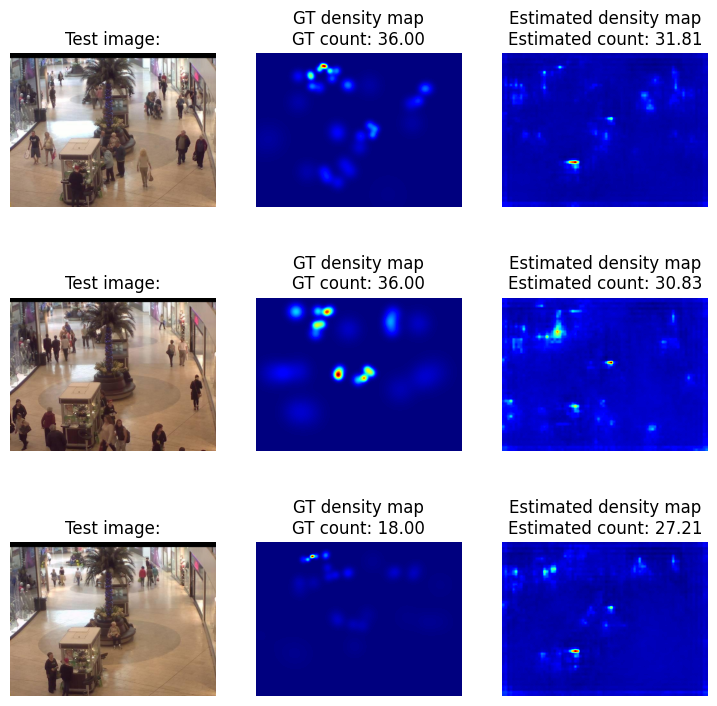

In [ ]:
to_print = 3
plt.figure(figsize=(9, 3 * to_print))

for i, (img_name, den_map_name) in enumerate(zip(test_img_names, test_den_names)):
    if i == to_print: break

    img = transform(Image.open(path_dataset + img_name).convert('RGB')).cuda()
    output = model(img.unsqueeze(0))
    estimated_den_map = output.squeeze().detach().cpu().numpy()

    img = cv2.imread(path_dataset + img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    den_map = h5py.File(path_dataset + den_map_name)
    den_map = np.asarray(den_map['density'])

    plt.subplot(to_print, 3, i * 3 + 1)
    plt.axis("off")
    plt.title("Test image:")
    plt.imshow(img)

    plt.subplot(to_print, 3, i * 3 + 2)
    plt.axis("off")
    plt.title("GT density map:")
    plt.title(f"GT density map\nGT count: {Test_labels[i]:.2f}")
    plt.imshow(den_map , cmap = cm.jet)
    print()

    estimated_count = np.sum(estimated_den_map)
    plt.subplot(to_print, 3, i * 3 + 3)
    plt.axis("off")
    plt.title(f"Estimated density map\nEstimated count: {estimated_count:.2f}")
    plt.imshow(estimated_den_map, cmap = cm.jet)

**Analysis**:

> The model works well, yielding a **very low MAE**.\
> Also, the generated density maps look decent.

Next, let's see if **fine-tunning** these weights on the training portion of the Mall dataset will improve its performance. Again as in (1), we will use a small portion of the data.

## (3) Fine-tunning
            

Here, we first attempted to use the [Authors code](https://github.com/leeyeehoo/CSRNet-pytorch), as it's convinient for fine-tunning, by just adding the argument --pre.

However, as we discovered, the code is quite inefficient, and, as we already mentioned, it incorporates data augmentation, leading to slow training even for a small number of epochs. We have decided to keep the code here, even though it won't be used. Below, **we introduce our own implementation for fine-tuning**.


## Using the authors' code

To do this, an additional change needs to be done for loading the weights, as their code expects the torch format, while we have .npz:

    print("=> loading checkpoint '{}'".format(args.pre))
    checkpoint = np.load(args.pre)
    checkpoint = {layer: torch.from_numpy(mat) for layer, mat in checkpoint.items()}
    model.load_state_dict(checkpoint)
    print("=> loaded checkpoint '{}'".format(args.pre))

In [6]:
%cd /content/drive/MyDrive/CrowdCounting/CSRNet-pytorch

/content/drive/MyDrive/CrowdCounting/CSRNet-pytorch


In [7]:
%pwd

'/content/drive/MyDrive/CrowdCounting/CSRNet-pytorch'

In [8]:
%ls /content/drive/MyDrive/CrowdCounting/Models/weights_pschaus.npz

/content/drive/MyDrive/CrowdCounting/Models/weights_pschaus.npz


In [9]:
!python train.py /content/drive/MyDrive/CrowdCounting/Data/mall_dataset/train_img.json /content/drive/MyDrive/CrowdCounting/Data/mall_dataset/val_img.json --pre /content/drive/MyDrive/CrowdCounting/Models/weights_pschaus.npz 0 pretrained_1_


Using device: cuda:0 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 528M/528M [00:05<00:00, 108MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.forma

## Custom implementation

In [15]:
# Define the fine-tuning parameters
learning_rate = 1e-5
epochs = 5
batch_size = 16

# Initialize the model
model = CSRNet().cuda()

# Load the pre-trained weights
checkpoint = np.load("/content/drive/MyDrive/CrowdCounting/Models/weights_pschaus.npz")
checkpoint = {layer: torch.from_numpy(mat) for layer, mat in checkpoint.items()}
model.load_state_dict(checkpoint)

# Define the optimizer and loss function
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [16]:
class CrowdCountingDataset(Dataset):
    def __init__(self, image_names, transform=None):
        self.image_names = image_names
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        img_name = self.image_names[index]
        img_path = os.path.join(path_dataset, self.image_names[index])
        density_map_path = os.path.join(path_dataset, img_name[:-4] +'.h5')

        img = Image.open(img_path).convert('RGB')

        # Load density map from h5 file
        with h5py.File(density_map_path, 'r') as h5f:
            density_map = np.asarray(h5f['density'])

        density_map = cv2.resize(density_map, (int(density_map.shape[1] / 8), int(density_map.shape[0] / 8)),
                                   interpolation=cv2.INTER_CUBIC) * (8 ** 2)

        density_map = np.expand_dims(density_map, axis=0)

        if self.transform:
            img = self.transform(img)

        return img, torch.from_numpy(density_map)

In [8]:
train_indices = [img_names.index(name) for name in train_img_names]
Train_labels = [num_heads_list[idx] for idx in train_indices]

val_indices = [img_names.index(name) for name in val_img_names]
Val_labels = [num_heads_list[idx] for idx in val_indices]

# Create custom datasets and dataloaders
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225]),])
train_dataset = CrowdCountingDataset(train_img_names, transform=transform)
val_dataset = CrowdCountingDataset(val_img_names, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
sample_index = 0
sample = train_dataset[sample_index]

# Unpack the sample into img and target
img, target = sample

# Print information about the sample
print("Image shape:", img.shape)  # Assuming img is a PyTorch tensor
print("Target shape:", target.shape)  #

Image shape: torch.Size([3, 480, 640])
Target shape: torch.Size([1, 60, 80])


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Epoch 1/5, Training Loss: 0.00042067330246532545, Validation Loss: 0.00038103040715213864




100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Epoch 2/5, Training Loss: 0.0003195530977488185, Validation Loss: 0.00033189569367095826




100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Epoch 3/5, Training Loss: 0.00029176466778153555, Validation Loss: 0.0003079634654568508




100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Epoch 4/5, Training Loss: 0.0002754106711816146, Validation Loss: 0.00029956702492199837




100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Epoch 5/5, Training Loss: 0.0002656741459051975, Validation Loss: 0.0002961261343443766




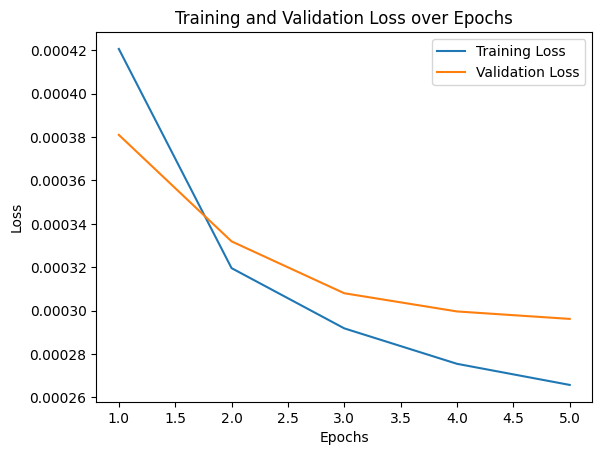

In [17]:
# Lists to store loss values
train_losses = []
valid_losses = []

# Fine-tune the model
for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0

    for img, target in tqdm(train_loader, total=len(train_loader)):
        img = img.cuda()
        target = target.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(img)
        loss = criterion(output, target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # End of training epoch
    average_train_loss = running_train_loss / len(train_loader)
    train_losses.append(average_train_loss)

    # Validation
    model.eval()
    running_valid_loss = 0.0

    with torch.no_grad():
        for img_val, target_val in tqdm(val_loader, total=len(val_loader)):
            img_val = img_val.cuda()
            target_val = target_val.cuda()

            output_val = model(img_val)
            loss_val = criterion(output_val, target_val)
            running_valid_loss += loss_val.item()

    average_valid_loss = running_valid_loss / len(val_loader)
    valid_losses.append(average_valid_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {average_train_loss}, Validation Loss: {average_valid_loss}")

    # Save the model after each epoch
    torch.save(model.state_dict(), f"/content/drive/MyDrive/CrowdCounting/Models/fine_tuned_model_epoch_{epoch + 1}.pth")
    print('\n')

# Save the fine-tuned model
torch.save(model.state_dict(), "/content/drive/MyDrive/CrowdCounting/Models/fine_tuned_model_final.pth")

# Plot the training and validation loss
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [18]:
# test_dataset = CrowdCountingDataset(test_img_names, transform=transform)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

mse_error = 0
mae_error = 0
mape_error = 0
N = len(Test_labels)

for (img_name, target) in tqdm(zip(test_img_names, Test_labels), total=len(Test_labels)):
    img = transform(Image.open(path_dataset + img_name).convert('RGB')).cuda()
    output = model(img.unsqueeze(0))
    prediction = int(output.detach().cpu().sum().numpy())
    mse_error += np.mean(np.square(np.sum(prediction) - target))
    mae_error += np.mean(np.abs(np.sum(prediction) - target))
    mape_error += np.mean(np.abs((np.sum(prediction) - target) / target)) * 100

mse = round(mse_error / N, 2)
mae = round(mae_error / N, 2)
mape = round(mape_error / N, 2)

print(f'\n\nMSE: {mse}, MAE: {mae}, MAPE: {mape}')

100%|██████████| 400/400 [00:25<00:00, 15.69it/s]



MSE: 69.15, MAE: 6.68, MAPE: 20.34


**Analysis**:

> Initially we run the fine-tunning procedure for 20 epochs. As we can observe from the plot below for the train and validation curves, it was apparent that with the chosen configuration, this many epochs lead to overfitting:

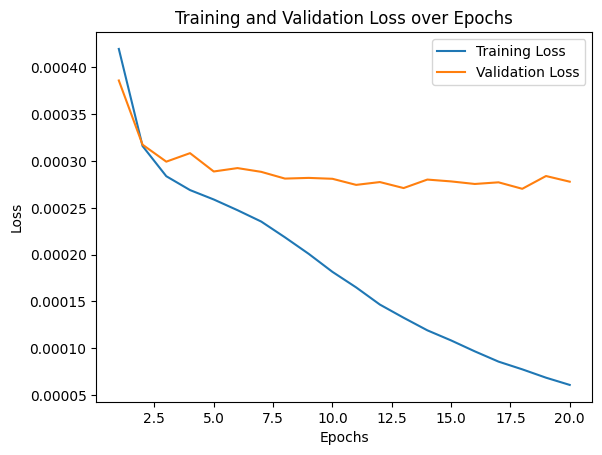

> Because of this, we've proceeded with just 5 epochs, for a more robust model, but even this one didn't yield any improvement over the basic Transfer learning model. On the contrary, the MAE and MSE are worse after attempting to fine-tune.

## (4) Training a Regressor

Here, we will attempt to use the **CSRNet as a feature extractor**, and train a **Dense layer** on top of it, in order **to perform regression**.

We will try just two configurations: just one Dense layer, and two Dense layers + Dropout.

In [7]:
class FeatureExtractor(nn.Module):
    def __init__(self, pretrained_model):
        super(FeatureExtractor, self).__init__()
        self.csrnet = pretrained_model  # Use the entire CSRNet as the feature extractor

    def forward(self, x):
        x = self.csrnet(x)
        return x

class CustomDataset(Dataset):
    def __init__(self, img_names, targets, transform=None):
        self.img_names = img_names
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(path_dataset, self.img_names[idx])
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        target = self.targets[idx]
        return img, target

In [8]:
# Load data
train_indices = [img_names.index(name) for name in train_img_names]
Train_labels = [num_heads_list[idx] for idx in train_indices]

val_indices = [img_names.index(name) for name in val_img_names]
Val_labels = [num_heads_list[idx] for idx in val_indices]

# Create custom datasets
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225]),])
train_dataset = CustomDataset(train_img_names, Train_labels, transform=transform)
val_dataset = CustomDataset(val_img_names, Val_labels, transform=transform)
test_dataset = CustomDataset(test_img_names, Test_labels, transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

checkpoint_dir = '/content/drive/MyDrive/CrowdCounting/Models/'

### (4.1) One Dense layer

In [ ]:
class CustomRegressionModel(nn.Module):
    def __init__(self, feature_extractor):
        super(CustomRegressionModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(60 * 80, 1)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

In [ ]:
# Load CSRNet model
model = CSRNet().cuda()

# Load weights
checkpoint = np.load("/content/drive/MyDrive/CrowdCounting/Models/weights_pschaus.npz")
checkpoint = {layer: torch.from_numpy(mat) for layer, mat in checkpoint.items()}
model.load_state_dict(checkpoint)

# Freeze the layers in the feature extractor
feature_extractor = FeatureExtractor(model)
for param in feature_extractor.parameters():
    param.requires_grad = False

# Create custom regression model
regression_model = CustomRegressionModel(feature_extractor).cuda()

# Initialize dense layer with RandomNormal
nn.init.normal_(regression_model.dense.weight, mean=1., std=0.001)
nn.init.constant_(regression_model.dense.bias, 0)
# Xavier/Glorot initialization for the dense layer
#nn.init.xavier_uniform_(regression_model.dense.weight)
#nn.init.constant_(regression_model.dense.bias, 0)

regression_model

CustomRegressionModel(
  (feature_extractor): FeatureExtractor(
    (csrnet): CSRNet(
      (frontend): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, k

In [ ]:
# Define the optimizer, loss function, and metrics
optimizer = Adam(regression_model.parameters(), lr=1e-2)
loss_fn = nn.L1Loss()  # MAE loss for regression
mse_metric = nn.MSELoss()

num_epochs = 20

for epoch in range(num_epochs):
    start_time = time.time()
    # Training
    regression_model.train()
    total_train_loss = 0.0
    for batch_idx, (batch_img, batch_target) in enumerate(train_loader):
        optimizer.zero_grad()

        # Move input and target tensors to GPU
        batch_img = torch.stack(tuple(img.cuda() for img in batch_img))
        batch_target = batch_target.unsqueeze(1).cuda()

        # Forward pass
        output = regression_model(batch_img)
        loss = loss_fn(output, batch_target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f'Train Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

    average_train_loss = total_train_loss / len(train_loader)
    print(f'Train Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {average_train_loss:.4f}')

    # Validation
    regression_model.eval()
    with torch.no_grad():
        total_val_loss = 0.0
        for batch_idx, (batch_img, batch_target) in enumerate(val_loader):
            # Move input and target tensors to GPU
            batch_img = torch.stack([img.cuda() for img in batch_img])
            batch_target = batch_target.unsqueeze(1).cuda()

            # Forward pass
            output = regression_model(batch_img)
            val_loss = loss_fn(output, batch_target)

            total_val_loss += val_loss.item()

            if batch_idx % 10 == 0:
                print(f'Validation Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(val_loader)}], Loss: {val_loss.item():.4f}')

        average_val_loss = total_val_loss / len(val_loader)
        print(f'Validation Epoch [{epoch+1}/{num_epochs}], Average Validation Loss: {average_val_loss:.4f}')

    epoch_time = time.time() - start_time

    # Print metrics
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {average_train_loss:.4f}, Average Validation Loss: {average_val_loss:.4f}')
    print(f'Time taken for epoch: {epoch_time:.2f} seconds\n')

    # Save model and optimizer state
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_regression_one_dense.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': regression_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': average_train_loss,
        'val_loss': average_val_loss,
    }, checkpoint_path)

Train Epoch [1/20], Batch [0/45], Loss: 3.5308
Train Epoch [1/20], Batch [10/45], Loss: 3.1196
Train Epoch [1/20], Batch [20/45], Loss: 3.0027
Train Epoch [1/20], Batch [30/45], Loss: 2.0915
Train Epoch [1/20], Batch [40/45], Loss: 3.6314
Train Epoch [1/20], Average Training Loss: 3.2819
Validation Epoch [1/20], Batch [0/5], Loss: 3.5293
Validation Epoch [1/20], Average Validation Loss: 3.6622
Epoch [1/20], Average Training Loss: 3.2819, Average Validation Loss: 3.6622
Time taken for epoch: 190.61 seconds

Train Epoch [2/20], Batch [0/45], Loss: 2.3576
Train Epoch [2/20], Batch [10/45], Loss: 3.4507
Train Epoch [2/20], Batch [20/45], Loss: 2.8172
Train Epoch [2/20], Batch [30/45], Loss: 3.4333
Train Epoch [2/20], Batch [40/45], Loss: 3.5864
Train Epoch [2/20], Average Training Loss: 3.0994
Validation Epoch [2/20], Batch [0/5], Loss: 3.2661
Validation Epoch [2/20], Average Validation Loss: 3.6067
Epoch [2/20], Average Training Loss: 3.0994, Average Validation Loss: 3.6067
Time taken for

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

regression_model.eval()

with torch.no_grad():
    test_loss = 0.0
    predictions = []

    for batch_img, batch_target in test_loader:
        batch_img = torch.stack(tuple(batch_img)).cuda()
        batch_target = batch_target.clone().detach().unsqueeze(1).to(torch.float32).cuda()

        # Forward pass
        output = regression_model(batch_img)
        test_loss += loss_fn(output, batch_target).item()

        # Collect predictions
        predictions.append(output.squeeze().cpu().numpy())

test_loss /= len(test_loader)

predictions_final = np.concatenate(predictions, axis=0)

mae = mean_absolute_error(Test_labels, predictions_final)
mse = mean_squared_error(Test_labels, predictions_final)

print(f'Test Loss: {test_loss:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')

Test Loss: 2.6901
MAE: 2.7169
MSE: 11.3156


**Analysis**:

> The regressor outperformed the pre-trained CSRNet. For the transfer learning case the results were:\
MAE: 3.44,  MSE: 17.95.\
> Here the MAE and MSE are much lower:\
> **MAE: 2.72**,  MSE: 11.32.


Let's finally try: Two dense layers + Dropout (0.1).

### (4.1) Two Dense layers + Dropout

In [9]:
class CustomRegressionModel(nn.Module):
    def __init__(self, feature_extractor):
        super(CustomRegressionModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(60 * 80, 512)
        self.dropout = nn.Dropout(0.1)
        self.dense2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = F.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        return x

In [10]:
# Load CSRNet model
model = CSRNet().cuda()

# Load weights
checkpoint = np.load("/content/drive/MyDrive/CrowdCounting/Models/weights_pschaus.npz")
checkpoint = {layer: torch.from_numpy(mat) for layer, mat in checkpoint.items()}
model.load_state_dict(checkpoint)

# Freeze the layers in the feature extractor
feature_extractor = FeatureExtractor(model)
for param in feature_extractor.parameters():
    param.requires_grad = False

# Create custom regression model
regression_model = CustomRegressionModel(feature_extractor).cuda()

# Initialize the weights of the first dense layer with RandomNormal
nn.init.normal_(regression_model.dense1.weight, mean=1., std=0.001)
nn.init.constant_(regression_model.dense1.bias, 0)

# Initialize the weights of the second dense layer with RandomNormal
nn.init.normal_(regression_model.dense2.weight, mean=1., std=0.001)
nn.init.constant_(regression_model.dense2.bias, 0)

regression_model

CustomRegressionModel(
  (feature_extractor): FeatureExtractor(
    (csrnet): CSRNet(
      (frontend): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, k

In [13]:
# Define the optimizer, loss function, and metrics
optimizer = Adam(regression_model.parameters(), lr=1e-2)
loss_fn = nn.L1Loss()  # MAE loss for regression
mse_metric = nn.MSELoss()

num_epochs = 20

for epoch in range(num_epochs):
    start_time = time.time()
    # Training
    regression_model.train()
    total_train_loss = 0.0
    for batch_idx, (batch_img, batch_target) in enumerate(train_loader):
        optimizer.zero_grad()

        # Move input and target tensors to GPU
        batch_img = torch.stack(tuple(img.cuda() for img in batch_img))
        batch_target = batch_target.unsqueeze(1).cuda()

        # Forward pass
        output = regression_model(batch_img)
        loss = loss_fn(output, batch_target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f'Train Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

    average_train_loss = total_train_loss / len(train_loader)
    print(f'Train Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {average_train_loss:.4f}')

    # Validation
    regression_model.eval()
    with torch.no_grad():
        total_val_loss = 0.0
        for batch_idx, (batch_img, batch_target) in enumerate(val_loader):
            # Move input and target tensors to GPU
            batch_img = torch.stack([img.cuda() for img in batch_img])
            batch_target = batch_target.unsqueeze(1).cuda()

            # Forward pass
            output = regression_model(batch_img)
            val_loss = loss_fn(output, batch_target)

            total_val_loss += val_loss.item()

            if batch_idx % 10 == 0:
                print(f'Validation Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(val_loader)}], Loss: {val_loss.item():.4f}')

        average_val_loss = total_val_loss / len(val_loader)
        print(f'Validation Epoch [{epoch+1}/{num_epochs}], Average Validation Loss: {average_val_loss:.4f}')

    epoch_time = time.time() - start_time

    # Print metrics
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {average_train_loss:.4f}, Average Validation Loss: {average_val_loss:.4f}')
    print(f'Time taken for epoch: {epoch_time:.2f} seconds\n')

    # Save model and optimizer state
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_regression_two_dense.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': regression_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': average_train_loss,
        'val_loss': average_val_loss,
    }, checkpoint_path)

Train Epoch [1/20], Batch [0/45], Loss: 5296.1211
Train Epoch [1/20], Batch [10/45], Loss: 3860.0947
Train Epoch [1/20], Batch [20/45], Loss: 2221.1475
Train Epoch [1/20], Batch [30/45], Loss: 1253.5964
Train Epoch [1/20], Batch [40/45], Loss: 680.0743
Train Epoch [1/20], Average Training Loss: 2329.8876
Validation Epoch [1/20], Batch [0/5], Loss: 449.8737
Validation Epoch [1/20], Average Validation Loss: 460.1897
Epoch [1/20], Average Training Loss: 2329.8876, Average Validation Loss: 460.1897
Time taken for epoch: 92.05 seconds

Train Epoch [2/20], Batch [0/45], Loss: 441.4915
Train Epoch [2/20], Batch [10/45], Loss: 177.6933
Train Epoch [2/20], Batch [20/45], Loss: 49.1927
Train Epoch [2/20], Batch [30/45], Loss: 15.7730
Train Epoch [2/20], Batch [40/45], Loss: 21.0873
Train Epoch [2/20], Average Training Loss: 107.0050
Validation Epoch [2/20], Batch [0/5], Loss: 14.8895
Validation Epoch [2/20], Average Validation Loss: 17.0984
Epoch [2/20], Average Training Loss: 107.0050, Average 

In [14]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

regression_model.eval()

with torch.no_grad():
    test_loss = 0.0
    predictions = []

    for batch_img, batch_target in test_loader:
        batch_img = torch.stack(tuple(batch_img)).cuda()
        batch_target = batch_target.clone().detach().unsqueeze(1).to(torch.float32).cuda()

        # Forward pass
        output = regression_model(batch_img)
        test_loss += loss_fn(output, batch_target).item()

        # Collect predictions
        predictions.append(output.squeeze().cpu().numpy())

test_loss /= len(test_loader)

predictions_final = np.concatenate(predictions, axis=0)

mae = mean_absolute_error(Test_labels, predictions_final)
mse = mean_squared_error(Test_labels, predictions_final)

print(f'Test Loss: {test_loss:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')

Test Loss: 2.7219
MAE: 2.7532
MSE: 11.7215


# Results

| Model                                | MAE  |
|--------------------------------------|------|
| Authors' code                        | 5.18 |
| Transfer Learning                    | 3.44 |
| Fine-tuning                          | 6.68 |
| 1 Dense layer Regressor              | **2.72** |
| 2 Dense layer + Dropout Regressor    | 2.75 |